# Hans 2024 data

Should probably formalize this as a Luigi or Airflow pipeline, but for now let's get everything set up interactively in notebooks so we can plot along the way.

## TODO:
1. Fix inclusion of too short fragments in scoring, or allow it on purpose.
2. Set longer length limit for Falcon, possibly using sequential device map or even CPU.
3. Score both matched fragments from row in Hans data. More data is better!
4. Shuffle data before train-test split such that training data is not mostly or all from the same sub-dataset.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load and combine the scored text fragment data from the Hans 2024 corpus.

In [2]:
datasets = {
    # 'cc_news': 'cc_news-scores.json',
    # 'pubmed': 'pubmed-scores.json',
    # 'cnn': 'cnn-scores.json'
    'falcon': 'falcon-7b_scores.json'
}

dataframes = []

for dataset, filename in datasets.items():

    print(f'\nRaw {dataset} dataset:')

    dataframe = pd.read_json(f'{config.HANS_DATA_PATH}/{filename}')

    # Replace and remove string 'OOM' and 'NAN' values
    dataframe.replace('NAN', np.nan, inplace = True)
    dataframe.replace('OOM', np.nan, inplace = True)
    dataframe.dropna(inplace = True)

    # Update name of score column, some earlier runs called
    # it by the old names
    dataframe.rename(columns = {
        'Binoculars score': 'Perplexity ratio score',
        'Observer peak memory (GB)': 'Reader peak memory (GB)',
        'Performer peak memory (GB)': 'Writer peak memory (GB)'
    }, inplace = True)

    dataframe.info()

    # Fix some d-types
    dataframe = dataframe.astype({
        'Fragment': int,
        'Fragment length (tokens)': int,
        'Reader peak memory (GB)': float,
        'Writer peak memory (GB)': float,
        'Perplexity': float,
        'Cross-perplexity': float,
        'Perplexity ratio score': float
    })

    # get rid of some unnecessary columns
    dataframe.drop([
        'Fragment', 
        'Reader peak memory (GB)', 
        'Writer peak memory (GB)'
    ], axis = 1, inplace = True)

    dataframes.append(dataframe)

# Combine the individual datasets
data_df = pd.concat(dataframes, axis = 0)

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

print('\nCombined dataset:')
data_df.info()


Raw falcon dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 69822 entries, 0 to 69840
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment                  69822 non-null  int64  
 1   Fragment length (tokens)  69822 non-null  object 
 2   Dataset                   69822 non-null  object 
 3   Source                    69822 non-null  object 
 4   String                    69822 non-null  object 
 5   Reader peak memory (GB)   69822 non-null  float64
 6   Writer peak memory (GB)   69822 non-null  float64
 7   Perplexity                69822 non-null  object 
 8   Cross-perplexity          69822 non-null  object 
 9   Perplexity ratio score    69822 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 5.9+ MB

Combined dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69822 entries, 0 to 69821
Data columns (total 7 columns):
 #   Column               

Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 54880 human text fragments and 14942 synthetic fragments.
Dataset is 21.4% synthetic fragments.


In [4]:
data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
0,306,pubmed-llama2-13,human,cells .\nthe pulp tissue swelled and appeared ...,2.568,2.707031,0.948773
1,356,pubmed-llama2-13,human,- capacity / low - affinity system providing w...,2.467,2.476562,0.996057
2,138,pubmed-llama2-13,human,"at the iefpcm - b3lyp/6 - 311++g(2d,2p)//iefpc...",3.719,3.599609,1.033098
3,164,cnn-llama2-13,human,already footed the cost and subsequently repor...,3.068,3.207031,0.956760
4,59,cnn-falcon7,synthetic,"people will be spared from the firing squad, i...",2.797,3.546875,0.788546


In [5]:
data_df.tail()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
69817,272,cnn-llama2-13,human,"Germany, which has sent more than 35,000 weapo...",2.576,2.570312,1.002280
69818,293,pubmed-llama2-13,human,amplitude ( see paragraphs below ) . more spec...,3.184,3.244141,0.981337
69819,379,pubmed-llama2-13,human,and item - total correlations .\ntest - retest...,2.658,2.701172,0.984093
69820,265,cnn-llama2-13,synthetic,used racial slurs in the past. In a deposition...,2.400,2.683594,0.894469
69821,240,pubmed-llama2-13,human,"cells , etc . ) .\nthe work reported here soug...",2.979,3.238281,0.919783


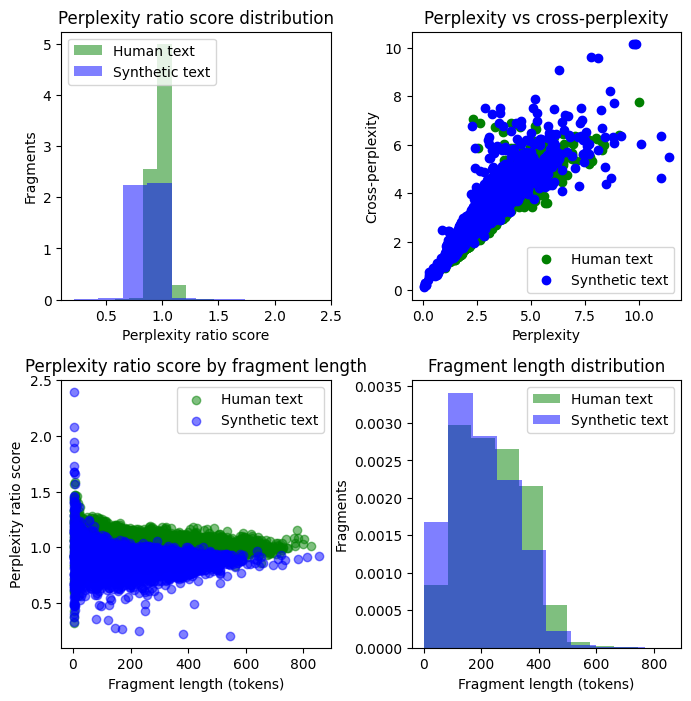

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Something strange in the fragment length vs perplexity ratio score plot - the minimum fragment length should be 50 words? Not sure what is going on... let's take a closer look.

In [7]:
short_fragments = human_fragments[human_fragments['Fragment length (tokens)'] < 10]
short_fragments.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
1171,4,pubmed-llama2-13,human,liver metabolism .,6.953,6.027344,1.153597
1648,4,pubmed-llama2-13,human,on time .,5.812,6.246094,0.930582
1926,4,pubmed-llama2-13,human,to treatment .,6.470,5.257812,1.230312
3535,5,cnn-llama2-13,human,of important green spaces.’,8.310,5.792969,1.434929
3594,6,pubmed-llama2-13,human,the alveolar ridge dimensions .,7.676,5.210938,1.473014


Yeah, looks like we have some weird stuff - apparently the extra ends of sentences get used? This could be a problem with how we did the sampling from the larger blocks of text contained in the Hans corpus. We don't have time to go back and fix it, but we can prevent those scores from being carried forward at this step. Let's threshold the length before we save.

Yeah, side note, found it. From perplexity_ratio.py in the benchmarking functions (line 147):

```text
    # If the slice length is greater than the
    # length of the input tokens, use all of
    # them
    if slice_length > total_length:
        slice_length = total_length
```

Also, bad terminological specificity here - we are actually talking about words.... not tokens.

In [8]:
data_df = data_df[data_df['Fragment length (tokens)'] > 50]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

OK - plot again just for sanity check.

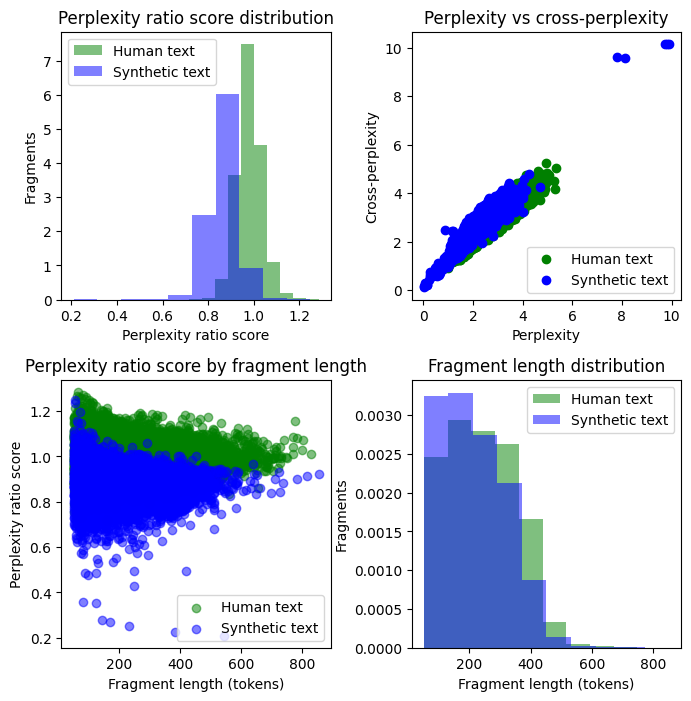

In [9]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'lower right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

OK, good, looks good, actually much better. Next....

In [10]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA

with open(output_file, 'w') as file:
    file.write(data_df.to_json())

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [11]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 54451 training examples
Have 13613 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13613 entries, 0 to 13612
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  13613 non-null  int64  
 1   Dataset                   13613 non-null  object 
 2   Source                    13613 non-null  object 
 3   String                    13613 non-null  object 
 4   Perplexity                13613 non-null  float64
 5   Cross-perplexity          13613 non-null  float64
 6   Perplexity ratio score    13613 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 744.6+ KB


And finally, save the split data for future use.

In [12]:
# Save testing data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())